/home/grtsinry43/.conda/envs/ml/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


成功从 Hugging Face🤗 加载 'online_shoppers_intention' 数据集

--- 数据集概览 ---


Administrative  Administrative_Duration  Informational  \
0               0                      0.0              0   
1               0                      0.0              0   
2               0                      0.0              0   
3               0                      0.0              0   
4               0                      0.0              0   

   Informational_Duration  ProductRelated  ProductRelated_Duration  \
0                     0.0               1                 0.000000   
1                     0.0               2                64.000000   
2                     0.0               1                 0.000000   
3                     0.0               2                 2.666667   
4                     0.0              10               627.500000   

   BounceRates  ExitRates  PageValues  SpecialDay Month  OperatingSystems  \
0         0.20       0.20         0.0         0.0   Feb                 1   
1         0.00       0.10         0.0         0.0   Feb                 2   
2         0.20       0.20         0.0         0.0   Feb                 4   
3         0.05       0.14         0.0         0.0   Feb                 3   
4         0.02       0.05         0.0         0.0   Feb                 3   

   Browser  Region  TrafficType        VisitorType  Weekend  Revenue  
0        1       1            1  Returning_Visitor    False    False  
1        2       1            2  Returning_Visitor    False    False  
2        1       9            3  Returning_Visitor    False    False  
3        2       2            4  Returning_Visitor    False    False  
4        3       1            4  Returning_Visitor     True    False


--- 数据信息 ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficT

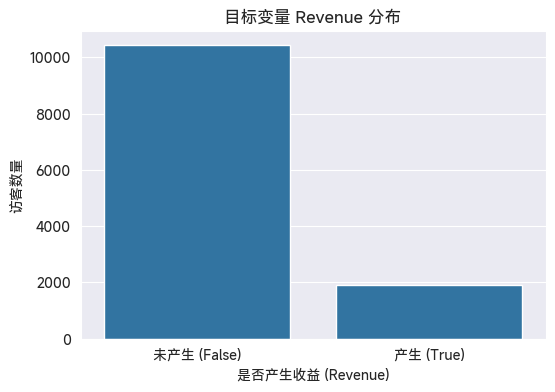

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm import tqdm  # 进度条
import time  # 计时
from collections import Counter
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, \
    classification_report
from sklearn.model_selection import train_test_split # 划分训练集和测试集
from sklearn.preprocessing import StandardScaler, OneHotEncoder # 标准化和独热编码
from sklearn.compose import ColumnTransformer # 列转换器，用于预处理
from sklearn.datasets import load_breast_cancer # 加载乳腺癌数据集（最后的任务用于对比）

plt.rcParams['font.sans-serif'] = ['MiSans']
plt.rcParams['axes.unicode_minus'] = False

# --- 加载原始数据集 ---
try:
    df = pd.read_csv("hf://datasets/schooly/online-shoppers-intention/online_shoppers_intention.csv")
    print("成功从 Hugging Face🤗 加载 'online_shoppers_intention' 数据集")
except Exception as e:
    print(f"错误: 数据集联网加载失败: {e}")
    # 如果联网失败，尝试加载本地副本
    try:
        df = pd.read_csv("online_shoppers_intention.csv")
        print("成功加载本地数据集 'online_shoppers_intention.csv'")
    except FileNotFoundError:
        print("错误: 本地也未找到 'online_shoppers_intention.csv'。请确保文件存在或网络连接正常。程序将退出。")
        exit()

# --- 初步数据探索 (先康康原始数据集) ---
print("\n--- 数据集概览 ---")
display(df.head())
print("\n--- 数据信息 ---")
print(df.info())
print("\n--- 缺失值检查 ---")
print(df.isnull().sum())

# 目标变量分布
print("\n--- 目标变量 'Revenue' 分布 ---")
print(df['Revenue'].value_counts(normalize=True))  # 归一化的类别计数
plt.figure(figsize=(6, 4))
sns.countplot(x='Revenue', data=df)
plt.title('目标变量 Revenue 分布')
plt.xlabel('是否产生收益 (Revenue)')
plt.ylabel('访客数量')
plt.xticks([0, 1], ['未产生 (False)', '产生 (True)'])
plt.show()

In [2]:
# --- 数据预处理 (原始数据集) ---
print("\n--- 开始数据预处理 ---")
# 将布尔值转换为整数
df['Weekend'] = df['Weekend'].astype(int)
df['Revenue'] = df['Revenue'].astype(int)  # 目标变量

# 识别类别特征和数值特征
# 'OperatingSystems', 'Browser', 'Region', 'TrafficType' 虽然是数值类型，但它们代表类别，所以也当类别处理
categorical_features = ['Month', 'VisitorType']
numerical_features = ['Administrative', 'Administrative_Duration', 'Informational',
                      'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
                      'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']
# 数值型的类别特征
numerical_categorical_features = ['OperatingSystems', 'Browser', 'Region', 'TrafficType']

# 确保将这些数值型类别特征转换为字符串类型，以便OneHotEncoder正确处理
for col in numerical_categorical_features:
    df[col] = df[col].astype(str)

all_categorical_features = categorical_features + numerical_categorical_features
print(f"所有识别出的类别特征: {all_categorical_features}")
print(f"所有识别出的数值特征: {numerical_features}")

# 创建预处理器
# 对于数值特征：进行标准化
# 对于类别特征：进行独热编码 (One-Hot Encoding)，drop='first'避免多重共线性
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), all_categorical_features)
    ],
    remainder='passthrough'  # 保留其他未指定列 (如 'Weekend')
)

# 分离特征和目标变量
X = df.drop('Revenue', axis=1)
y = df['Revenue']

# 应用预处理
X_processed = preprocessor.fit_transform(X)

# 如果 X_processed 是稀疏矩阵，转换为密集数组
if hasattr(X_processed, "toarray"):
    X_processed = X_processed.toarray()

print(f"\n--- 处理后的特征维度 ---")
print(f"X_processed.shape: {X_processed.shape}")

# 划分训练集和测试集
# 这里的 random_state 是为了结果可复现, stratify=y 确保类别比例在训练集和测试集中保持一致
X_train, X_test, y_train, y_test = train_test_split(X_processed, y.values, test_size=0.2, random_state=42, stratify=y)

print(f"训练集大小: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"测试集大小: X_test: {X_test.shape}, y_test: {y_test.shape}")
print("--- 数据预处理完成 ---")


--- 开始数据预处理 ---
所有识别出的类别特征: ['Month', 'VisitorType', 'OperatingSystems', 'Browser', 'Region', 'TrafficType']
所有识别出的数值特征: ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']

--- 处理后的特征维度 ---
X_processed.shape: (12330, 68)
训练集大小: X_train: (9864, 68), y_train: (9864,)
测试集大小: X_test: (2466, 68), y_test: (2466,)
--- 数据预处理完成 ---



--- 训练自定义逻辑回归模型 ---
开始逻辑回归训练，学习率=0.1, 最大迭代次数=2000
迭代 0, 损失: 0.6931
迭代 200, 损失: 0.2997
迭代 400, 损失: 0.2924
迭代 531: 损失变化小于容忍度 1e-05，模型已收敛。当前损失: 0.2906
逻辑回归训练完成。


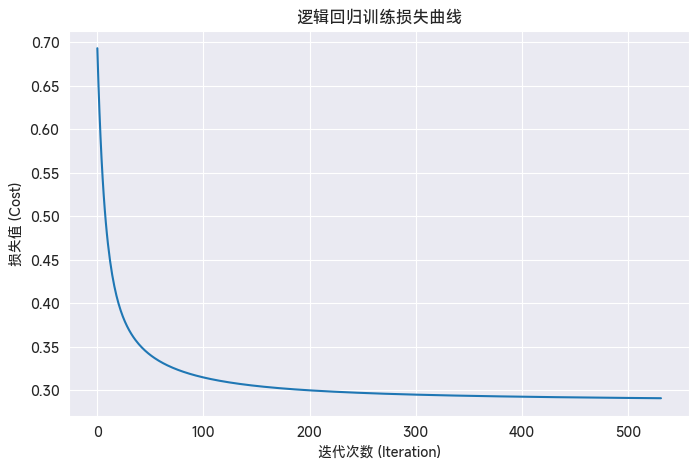


--- 逻辑回归模型评估 ---
准确率 (Accuracy): 0.8832

分类报告:
              precision    recall  f1-score   support

    不会购买 (0)       0.89      0.98      0.93      2084
     会购买 (1)       0.75      0.37      0.50       382

    accuracy                           0.88      2466
   macro avg       0.82      0.67      0.72      2466
weighted avg       0.87      0.88      0.87      2466


混淆矩阵:


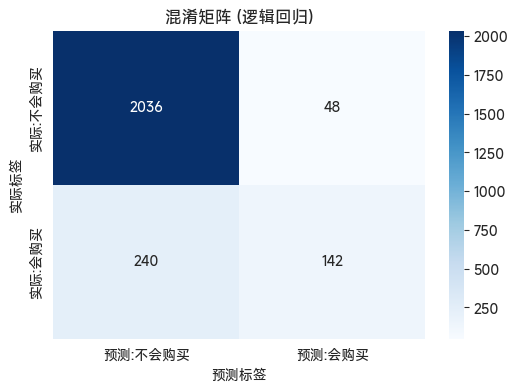

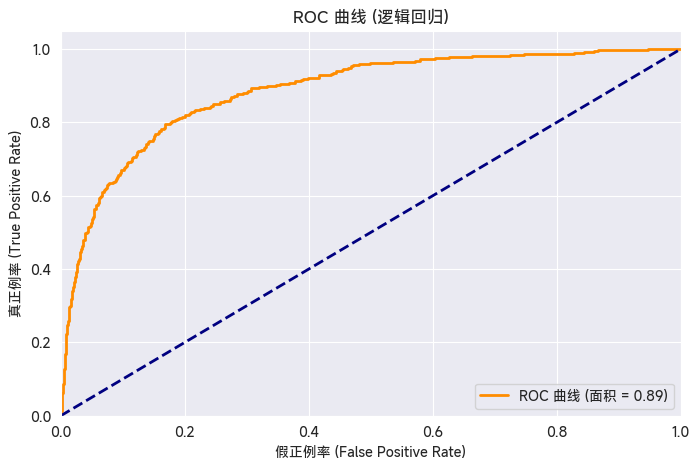

AUC值: 0.8854


In [3]:
# --- 从零实现逻辑回归 ---
class MyLogisticRegression:
    """
    自定义逻辑回归分类器。
    """

    def __init__(self, learning_rate=0.01, n_iterations=1000, verbose=False, tol=1e-4, early_stopping_rounds=None):
        """
        初始化函数。
        参数:
            learning_rate (float): 学习率。
            n_iterations (int): 最大迭代次数。
            verbose (bool): 是否打印训练过程中的损失。
            tol (float): 收敛的容忍度。如果两次迭代之间的损失变化小于此值，则认为收敛。
            early_stopping_rounds (int, optional): 早停轮数。如果在指定轮数内损失没有改善，则停止训练。
        """
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.weights = None  # 权重
        self.bias = None  # 偏置
        self.verbose = verbose
        self.costs = []  # 记录每次迭代的损失
        self.tol = tol
        self.early_stopping_rounds = early_stopping_rounds

    def _sigmoid(self, z):
        """Sigmoid激活函数，并进行数值裁剪防止溢出。"""
        z = np.clip(z, -500, 500)  # 防止np.exp()溢出
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        """
        训练模型。
        参数:
            X (numpy.ndarray): 特征数据。
            y (numpy.ndarray): 目标标签。
        """
        n_samples, n_features = X.shape
        # 初始化权重和偏置
        self.weights = np.zeros(n_features)
        self.bias = 0
        self.costs = []

        no_improvement_count = 0
        min_cost_for_early_stopping = float('inf')

        if self.verbose:
            print(f"开始逻辑回归训练，学习率={self.learning_rate}, 最大迭代次数={self.n_iterations}")

        for i in range(self.n_iterations):
            # 线性模型: z = X.w + b
            linear_model = np.dot(X, self.weights) + self.bias
            # 应用sigmoid函数得到预测概率
            y_predicted_proba = self._sigmoid(linear_model)

            # 计算梯度
            dw = (1 / n_samples) * np.dot(X.T, (y_predicted_proba - y))  # 权重梯度
            db = (1 / n_samples) * np.sum(y_predicted_proba - y)  # 偏置梯度

            # 更新权重和偏置
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

            # 计算并记录损失 (二元交叉熵损失)
            # 添加一个小的epsilon防止log(0)
            epsilon = 1e-9
            cost = - (1 / n_samples) * np.sum(
                y * np.log(y_predicted_proba + epsilon) + (1 - y) * np.log(1 - y_predicted_proba + epsilon))

            # 检查收敛性 (基于tol)
            if i > 0 and abs(self.costs[-1] - cost) < self.tol:
                if self.verbose:
                    print(f"迭代 {i}: 损失变化小于容忍度 {self.tol}，模型已收敛。当前损失: {cost:.4f}")
                self.costs.append(cost)
                break
            self.costs.append(cost)

            if self.verbose and (i % (self.n_iterations // 10) == 0 or i == self.n_iterations - 1 or i == 0):
                print(f"迭代 {i}, 损失: {cost:.4f}")

            # 早停逻辑
            if self.early_stopping_rounds:
                if cost < min_cost_for_early_stopping - self.tol:  # 必须有显著改善
                    min_cost_for_early_stopping = cost
                    no_improvement_count = 0
                else:
                    no_improvement_count += 1

                if no_improvement_count >= self.early_stopping_rounds:
                    if self.verbose:
                        print(f"早停: 在迭代 {i} 次时，连续 {self.early_stopping_rounds} 轮损失未显著改善。")
                    break
        if self.verbose:
            print("逻辑回归训练完成。")

    def predict_proba(self, X):
        """
        预测每个样本属于正类的概率。
        参数:
            X (numpy.ndarray): 特征数据。
        返回:
            numpy.ndarray: 每个样本属于正类的概率。
        """
        linear_model = np.dot(X, self.weights) + self.bias
        return self._sigmoid(linear_model)

    def predict(self, X, threshold=0.5):
        """
        根据概率预测类别标签。
        参数:
            X (numpy.ndarray): 特征数据。
            threshold (float): 概率阈值，大于此阈值的判为正类。
        返回:
            numpy.ndarray: 预测的类别标签 (0 或 1)。
        """
        y_predicted_proba = self.predict_proba(X)
        return np.array([1 if i > threshold else 0 for i in y_predicted_proba])


# --- 训练自定义逻辑回归模型 ---
print("\n--- 训练自定义逻辑回归模型 ---")
log_reg_model = MyLogisticRegression(learning_rate=0.1, n_iterations=2000, verbose=True, tol=1e-5,
                                     early_stopping_rounds=50)
log_reg_model.fit(X_train, y_train)

# 绘制损失曲线
plt.figure(figsize=(8, 5))
plt.plot(range(len(log_reg_model.costs)), log_reg_model.costs)
plt.xlabel("迭代次数 (Iteration)")
plt.ylabel("损失值 (Cost)")
plt.title("逻辑回归训练损失曲线")
plt.grid(True)
plt.show()

# --- 进行预测 ---
y_pred_proba_lr = log_reg_model.predict_proba(X_test)  # 获取概率用于ROC曲线
y_pred_labels_lr = log_reg_model.predict(X_test)  # 获取类别标签

# --- 模型评估 (Logistic Regression) ---
print("\n--- 逻辑回归模型评估 ---")
accuracy_lr = accuracy_score(y_test, y_pred_labels_lr)
print(f"准确率 (Accuracy): {accuracy_lr:.4f}")

print("\n分类报告:")
print(classification_report(y_test, y_pred_labels_lr, target_names=['不会购买 (0)', '会购买 (1)']))

print("\n混淆矩阵:")
cm_lr = confusion_matrix(y_test, y_pred_labels_lr)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=['预测:不会购买', '预测:会购买'],
            yticklabels=['实际:不会购买', '实际:会购买'])
plt.xlabel('预测标签')
plt.ylabel('实际标签')
plt.title('混淆矩阵 (逻辑回归)')
plt.show()

# ROC曲线和AUC
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)
plt.figure(figsize=(8, 5))
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2, label=f'ROC 曲线 (面积 = {roc_auc_lr:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # 对角线
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('假正例率 (False Positive Rate)')
plt.ylabel('真正例率 (True Positive Rate)')
plt.title('ROC 曲线 (逻辑回归)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
print(f"AUC值: {roc_auc_lr:.4f}")


--- 训练自定义SVM模型 ---
SVM训练: 使用的gamma值 = 0.0678 (基于 'scale')
SVM训练: 开始预计算核矩阵...
SVM训练: 核矩阵预计算完成，耗时 0.63 秒。
SVM训练: 开始SMO迭代，最大外部轮数 = 3


SVM训练进度: 100%|██████████| 3/3 [00:07<00:00,  2.51s/it, 本轮alpha改变数: 989, 耗时: 2.42s]



SVM训练: 已达到最大外部迭代轮数 (3)，最后一轮仍有 989 个alpha改变。
SVM训练完成。共找到 2479 个支持向量。

--- SVM模型评估 ---
准确率 (Accuracy): 0.8500

分类报告:
              precision    recall  f1-score   support

    不会购买 (0)       0.85      1.00      0.92      2084
     会购买 (1)       0.93      0.03      0.07       382

    accuracy                           0.85      2466
   macro avg       0.89      0.52      0.49      2466
weighted avg       0.86      0.85      0.79      2466


混淆矩阵:


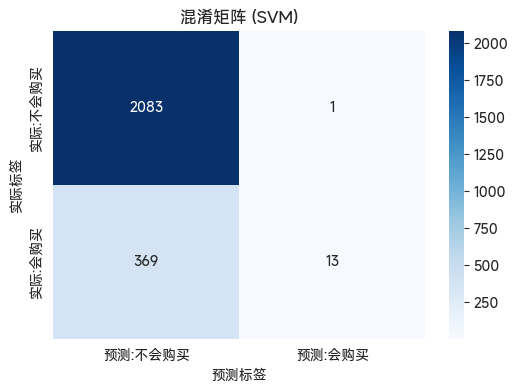

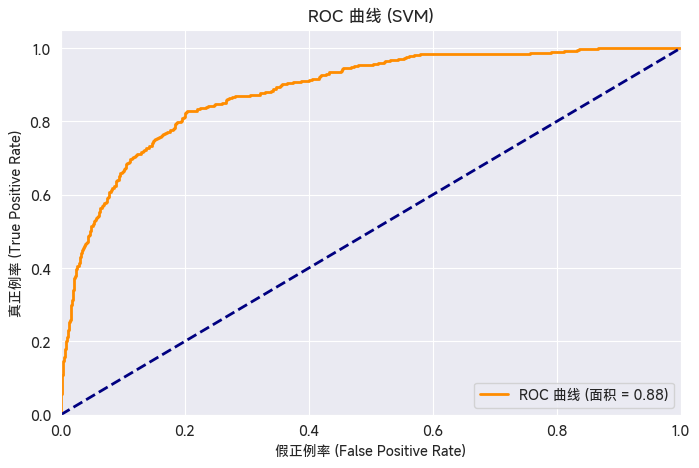

AUC值: 0.8823


In [4]:
# --- 从零实现SVM (SMO) ---
def linear_kernel(X1, X2):
    """线性核函数"""
    return np.dot(X1, X2.T)


def rbf_kernel(X1, X2, gamma=0.1):
    """
    径向基核函数 (RBF Kernel)。
    参数:
        X1, X2 (numpy.ndarray): 输入数据。
        gamma (float): RBF核的参数。
    返回:
        numpy.ndarray: 核矩阵。
    """
    if X1.ndim == 1: X1 = X1[np.newaxis, :]  # 确保是二维
    if X2.ndim == 1: X2 = X2[np.newaxis, :]
    # 使用广播计算平方欧氏距离 (a-b)^2 = a^2 - 2ab + b^2
    X1_norm_sq = np.sum(X1 ** 2, axis=1)[:, np.newaxis]
    X2_norm_sq = np.sum(X2 ** 2, axis=1)[np.newaxis, :]
    K_dot = np.dot(X1, X2.T)
    sq_dists = X1_norm_sq + X2_norm_sq - 2 * K_dot
    # 确保 sq_dists 中的值非负，避免因浮点数精度问题导致 np.exp 中出现复数
    sq_dists = np.maximum(sq_dists, 0)
    return np.exp(-gamma * sq_dists)

class SMO_SVM:
    """
    使用简化SMO算法实现的SVM分类器。
    """

    def __init__(self, C=1.0, kernel='rbf', gamma='scale', tol=1e-3, max_outer_passes=5):
        """
        初始化函数。
        参数:
            C (float): 惩罚参数。
            kernel (str): 核函数类型 ('rbf' 或 'linear')。
            gamma (float or str): RBF核的参数。可以是浮点数，或 'scale', 'auto'。
            tol (float): KKT条件检查的容忍度。
            max_outer_passes (int): 最大外部迭代轮数。在这些轮数内，如果算法未通过“无alpha改变”收敛，则强制停止。
                                    这也是tqdm进度条的总轮数。
        """
        self.C = C
        self.tol = tol
        self.max_outer_passes = max_outer_passes  # 控制外部循环的最大次数
        self._kernel_str = kernel
        self.gamma_val = gamma
        self.alphas = None  # 拉格朗日乘子
        self.b = 0  # 偏置项
        self.X = None  # 训练数据特征
        self.y_svm = None  # 训练数据标签 (-1, 1)
        self.K = None  # 预计算的核矩阵
        self.actual_gamma = None  # 实际使用的gamma值

    def _get_gamma(self, X):
        """根据输入和初始化参数计算实际的gamma值。"""
        if isinstance(self.gamma_val, (int, float)):
            return self.gamma_val
        # 如果X的样本量为0或特征数为0，或者X的方差为0，则返回一个默认值 (如1.0)，避免除零错误
        if X.shape[0] * X.shape[1] == 0 or X.var() == 0:
            return 1.0
        if self.gamma_val == 'scale':
            return 1.0 / (X.shape[1] * X.var())
        elif self.gamma_val == 'auto':
            return 1.0 / X.shape[1]
        else:  # 默认情况
            print(f"警告: 未识别的gamma值 '{self.gamma_val}', 将使用默认值 0.1。")
            return 0.1

    def _select_kernel(self, X1, X2, gamma_val_runtime):
        """根据选择的核函数类型计算核矩阵。"""
        if self._kernel_str == 'rbf':
            return rbf_kernel(X1, X2, gamma=gamma_val_runtime)
        elif self._kernel_str == 'linear':
            return linear_kernel(X1, X2)
        else:
            raise ValueError(f"不支持的核函数类型: {self._kernel_str}")

    def fit(self, X, y):
        """
        使用SMO算法训练SVM模型。
        """
        self.y_svm = np.where(y <= 0, -1, 1)  # 将标签转换为-1, 1
        n_samples, n_features = X.shape
        self.X = X

        self.actual_gamma = self._get_gamma(X)
        print(f"SVM训练: 使用的gamma值 = {self.actual_gamma:.4f} (基于 '{self.gamma_val}')")

        self.alphas = np.zeros(n_samples)
        self.b = 0

        print("SVM训练: 开始预计算核矩阵...")
        start_kernel_time = time.time()
        self.K = self._select_kernel(self.X, self.X, self.actual_gamma)
        print(f"SVM训练: 核矩阵预计算完成，耗时 {time.time() - start_kernel_time:.2f} 秒。")

        # outer_pass_count 控制外部循环，对应tqdm的进度
        # converged_passes_count 计连续多少轮没有alpha改变
        outer_pass_count = 0

        print(f"SVM训练: 开始SMO迭代，最大外部轮数 = {self.max_outer_passes}")
        with tqdm(total=self.max_outer_passes, desc="SVM训练进度") as pbar:
            while outer_pass_count < self.max_outer_passes:
                num_changed_alphas = 0  # 当前轮中改变的alpha数量
                iter_start_time = time.time()

                for i in range(n_samples):  # 内层循环遍历所有样本
                    # 计算样本i的误差Ei = f(xi) - yi
                    Ei = self._decision_function_single(i) - self.y_svm[i]

                    # 检查样本i是否违反KKT条件
                    if ((self.y_svm[i] * Ei < -self.tol and self.alphas[i] < self.C) or
                            (self.y_svm[i] * Ei > self.tol and self.alphas[i] > 0)):

                        # 启发式选择第二个样本j (简化：随机选择一个不为i的样本)
                        j_candidates = [idx for idx in range(n_samples) if idx != i]
                        if not j_candidates: continue  # 如果只有一个样本，无法选择j
                        j = np.random.choice(j_candidates)

                        Ej = self._decision_function_single(j) - self.y_svm[j]

                        alpha_i_old, alpha_j_old = self.alphas[i].copy(), self.alphas[j].copy()

                        # 计算alpha_j的边界L和H
                        if self.y_svm[i] != self.y_svm[j]:
                            L = max(0, self.alphas[j] - self.alphas[i])
                            H = min(self.C, self.C + self.alphas[j] - self.alphas[i])
                        else:
                            L = max(0, self.alphas[i] + self.alphas[j] - self.C)
                            H = min(self.C, self.alphas[i] + self.alphas[j])

                        if L == H: continue  # 如果L和H相等，无法优化

                        # 计算eta = Kii + Kjj - 2Kij
                        eta = self.K[i, i] + self.K[j, j] - 2 * self.K[i, j]
                        if eta <= 0: continue  # 如果eta非正，无法优化 (通常eta > 0)

                        # 更新alpha_j
                        self.alphas[j] += self.y_svm[j] * (Ei - Ej) / eta
                        self.alphas[j] = np.clip(self.alphas[j], L, H)  # 裁剪到边界内

                        # 如果alpha_j的变化很小，则忽略此次更新
                        if abs(self.alphas[j] - alpha_j_old) < 1e-5:
                            continue

                        # 更新alpha_i
                        self.alphas[i] += self.y_svm[i] * self.y_svm[j] * (alpha_j_old - self.alphas[j])

                        # 更新偏置b
                        b1 = self.b - Ei - self.y_svm[i] * (self.alphas[i] - alpha_i_old) * self.K[i, i] \
                             - self.y_svm[j] * (self.alphas[j] - alpha_j_old) * self.K[i, j]
                        b2 = self.b - Ej - self.y_svm[i] * (self.alphas[i] - alpha_i_old) * self.K[i, j] \
                             - self.y_svm[j] * (self.alphas[j] - alpha_j_old) * self.K[j, j]

                        if 0 < self.alphas[i] < self.C:
                            self.b = b1
                        elif 0 < self.alphas[j] < self.C:
                            self.b = b2
                        else:
                            self.b = (b1 + b2) / 2

                        num_changed_alphas += 1

                pbar.update(1)  # 更新tqdm进度条
                outer_pass_count += 1  # 外部迭代轮数增加

                iter_time = time.time() - iter_start_time
                pbar.set_postfix_str(f"本轮alpha改变数: {num_changed_alphas}, 耗时: {iter_time:.2f}s")

                if num_changed_alphas == 0:
                    print(f"\nSVM训练: 在第 {outer_pass_count} 轮外部迭代后，没有alpha发生改变，模型已收敛。")
                    break  # 收敛，提前退出

            if outer_pass_count >= self.max_outer_passes and num_changed_alphas > 0:
                print(
                    f"\nSVM训练: 已达到最大外部迭代轮数 ({self.max_outer_passes})，最后一轮仍有 {num_changed_alphas} 个alpha改变。")

        sv_indices = np.where(self.alphas > 1e-5)[0]
        print(f"SVM训练完成。共找到 {len(sv_indices)} 个支持向量。")

    def _decision_function_single(self, i):
        """计算训练样本i的决策函数值 f(xi)，使用预计算的核矩阵。"""
        return np.sum(self.alphas * self.y_svm * self.K[:, i]) + self.b

    def project(self, X_test):
        """
        计算新数据点的决策函数值 (即wx+b的值，或在核空间中的对应值)。
        参数:
            X_test (numpy.ndarray): 测试数据特征。
        返回:
            numpy.ndarray: 测试数据的决策函数值。
        """
        if self.X is None: raise ValueError("SVM模型尚未训练 (X is None)。")
        # 计算测试数据与所有训练支持向量之间的核函数
        K_test = self._select_kernel(self.X, X_test, self.actual_gamma)
        # 决策函数: sum(alpha_i * y_i * K(x_i, x_test)) + b
        return np.dot(self.alphas * self.y_svm, K_test) + self.b

    def predict(self, X_test):
        """
        预测测试数据的类别标签。
        参数:
            X_test (numpy.ndarray): 测试数据特征。
        返回:
            numpy.ndarray: 预测的类别标签 (0 或 1)。
        """
        # 决策函数值大于等于0判为正类(1)，否则为负类(0，对应原始的-1)
        return np.where(self.project(X_test) >= 0, 1, 0)


# --- 训练自定义SVM模型 ---
print("\n--- 训练自定义SVM模型 ---")
# emm从零实现的SMO会比较慢，尤其这个数据集好大噢。为了演示，max_outer_passes设置得较小。
svm_model = SMO_SVM(C=1.0, kernel='rbf', gamma='scale', tol=1e-3, max_outer_passes=3)  # max_outer_passes 较小以加速
svm_model.fit(X_train, y_train)  # y_train 是 0/1

# --- 进行预测 ---
y_project_svm = svm_model.project(X_test)  # 获取决策函数值用于ROC
y_pred_labels_svm = svm_model.predict(X_test)  # 获取类别标签

print("\n--- SVM模型评估 ---")
accuracy_svm = accuracy_score(y_test, y_pred_labels_svm)
print(f"准确率 (Accuracy): {accuracy_svm:.4f}")
print("\n分类报告:")
# zero_division=0 避免在某个类别没有预测样本时产生警告
print(classification_report(y_test, y_pred_labels_svm, target_names=['不会购买 (0)', '会购买 (1)'], zero_division=0))

print("\n混淆矩阵:")
cm_svm = confusion_matrix(y_test, y_pred_labels_svm)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', xticklabels=['预测:不会购买', '预测:会购买'],
            yticklabels=['实际:不会购买', '实际:会购买'])
plt.xlabel('预测标签')
plt.ylabel('实际标签')
plt.title('混淆矩阵 (SVM)')
plt.show()

# ROC曲线和AUC (使用决策函数值 y_project_svm)
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_project_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)
plt.figure(figsize=(8, 5))
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=2, label=f'ROC 曲线 (面积 = {roc_auc_svm:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('假正例率 (False Positive Rate)')
plt.ylabel('真正例率 (True Positive Rate)')
plt.title('ROC 曲线 (SVM)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
print(f"AUC值: {roc_auc_svm:.4f}")


--- 训练自定义决策树模型 ---
开始决策树训练，最大深度=7, 最小分裂样本数=10
决策树训练完成。

--- 决策树模型评估 ---
准确率 (Accuracy): 0.8954

分类报告:
              precision    recall  f1-score   support

    不会购买 (0)       0.92      0.96      0.94      2084
     会购买 (1)       0.70      0.57      0.63       382

    accuracy                           0.90      2466
   macro avg       0.81      0.76      0.78      2466
weighted avg       0.89      0.90      0.89      2466


混淆矩阵:


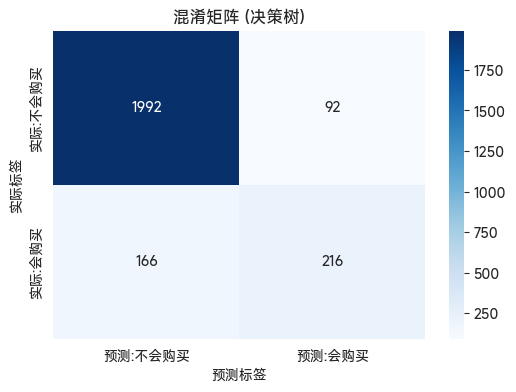

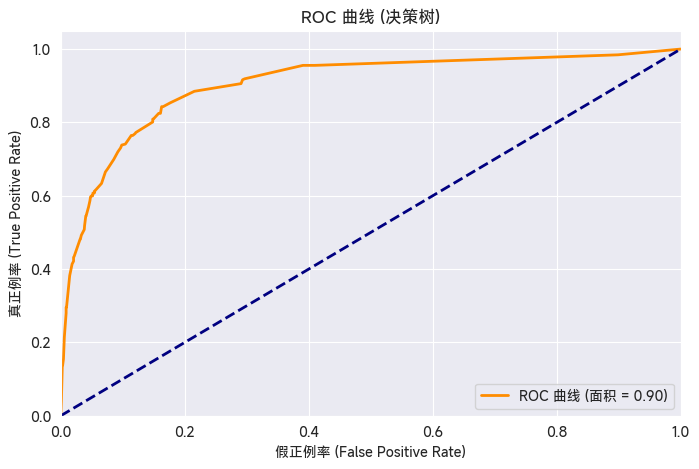

AUC值: 0.9028


In [5]:
# --- 从零实现决策树 ---
class MyDecisionTreeClassifier:
    """
    自定义决策树分类器。
    """

    def __init__(self, max_depth=None, min_samples_split=2, criterion='gini', max_features=None):
        """
        初始化函数。
        参数:
            max_depth (int, optional): 树的最大深度。
            min_samples_split (int): 节点分裂所需的最小样本数。
            criterion (str): 不纯度度量标准 ('gini' 或 'entropy')。
            max_features (int, float, str, optional): 寻找最佳分裂时考虑的特征数量。
                                                      用于随机森林中的特征子抽样。
        """
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.criterion = criterion
        self.tree = None  # 训练好的决策树结构
        self.max_features = max_features  # 用于随机森林的特征子集大小

    def _calculate_impurity(self, y):
        """计算给定目标标签的不纯度（基尼指数或熵）。"""
        if len(y) == 0: return 0
        class_counts = Counter(y)  # 统计各类别数量
        total_samples = len(y)
        impurity = 0
        if self.criterion == 'gini':  # 基尼指数 = sum(pk * (1-pk))
            for cls_count in class_counts.values():
                p_k = cls_count / total_samples
                impurity += p_k * (1 - p_k)
            return impurity
        elif self.criterion == 'entropy':  # 信息熵 = -sum(pk * log2(pk))
            for cls_count in class_counts.values():
                p_k = cls_count / total_samples
                if p_k > 0: impurity -= p_k * np.log2(p_k)
            return impurity
        else:
            raise ValueError(f"未知的评价标准 (criterion): {self.criterion}")

    def _calculate_information_gain(self, X_column, y, threshold):
        """计算给定特征列和阈值下的信息增益。"""
        parent_impurity = self._calculate_impurity(y)  # 父节点不纯度

        # 根据阈值划分数据
        left_indices = X_column <= threshold
        right_indices = X_column > threshold
        y_left, y_right = y[left_indices], y[right_indices]

        if len(y_left) == 0 or len(y_right) == 0: return 0  # 如果划分导致一个子集为空，则增益为0

        n, n_left, n_right = len(y), len(y_left), len(y_right)
        # 子节点加权不纯度
        child_impurity = (n_left / n) * self._calculate_impurity(y_left) + \
                         (n_right / n) * self._calculate_impurity(y_right)

        information_gain = parent_impurity - child_impurity  # 信息增益
        return information_gain

    def _find_best_split(self, X, y):
        """寻找最佳分裂特征和阈值。"""
        best_gain = -1.0  # 初始化为负值，确保任何正增益都更好
        best_feature_idx, best_threshold = None, None
        n_samples, n_features_total = X.shape

        # 特征子抽样 (用于随机森林)
        feature_indices_to_consider = np.arange(n_features_total)
        if self.max_features is not None and self.max_features < n_features_total:
            # 根据 self.max_features (可能是整数、浮点数比例或字符串如 'sqrt') 确定抽样数量
            if isinstance(self.max_features, float) and 0 < self.max_features < 1:
                num_feat_to_sample = int(self.max_features * n_features_total)
            elif isinstance(self.max_features, int):
                num_feat_to_sample = self.max_features
            # (可以添加 'sqrt', 'log2' 等逻辑，但这里简化为需要预先计算好的整数值)
            else:  # 默认或无法解析时，使用所有特征
                num_feat_to_sample = n_features_total

            num_feat_to_sample = max(1, min(num_feat_to_sample, n_features_total))  # 保证在[1, n_features_total]
            feature_indices_to_consider = np.random.choice(n_features_total, num_feat_to_sample, replace=False)

        for feature_idx in feature_indices_to_consider:
            X_column = X[:, feature_idx]
            # 对于数值特征，可能的阈值是排序后唯一值的中间点
            # 简化做法: 尝试每个唯一值作为阈值 (或它们之间的中点)
            thresholds = np.unique(X_column)
            if len(thresholds) > 10:  # 如果唯一值过多，抽样一部分阈值避免计算量过大
                # 使用百分位数生成阈值候选项
                percentiles = np.arange(10, 100, 10)  # 10%, 20%, ..., 90%
                thresholds = np.percentile(X_column, percentiles)
                thresholds = np.unique(thresholds)  # 去除重复值

            for threshold in thresholds:
                gain = self._calculate_information_gain(X_column, y, threshold)
                if gain > best_gain:
                    best_gain = gain
                    best_feature_idx = feature_idx
                    best_threshold = threshold
        return best_feature_idx, best_threshold, best_gain

    def _build_tree(self, X, y, depth=0):
        """递归构建决策树。"""
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))  # 当前节点中类别的数量

        # 停止条件
        if (self.max_depth is not None and depth >= self.max_depth) or \
                n_labels == 1 or \
                n_samples < self.min_samples_split:
            # 叶节点：值为多数类，并存储类别概率
            leaf_value = Counter(y).most_common(1)[0][0]
            leaf_proba = {cls: count / n_samples for cls, count in Counter(y).items()}
            return {'value': leaf_value, 'proba': leaf_proba, 'is_leaf': True, 'samples': n_samples, 'depth': depth}

        best_feature_idx, best_threshold, best_gain = self._find_best_split(X, y)

        # 如果信息增益很小 (例如，小于0.001)，也停止分裂 (预剪枝，避免过拟合)
        current_proba = {cls: count / n_samples for cls, count in Counter(y).items()}  # 当前节点的类别概率
        if best_gain <= 1e-4:  # 可调参数
            leaf_value = Counter(y).most_common(1)[0][0]
            return {'value': leaf_value, 'proba': current_proba, 'is_leaf': True, 'samples': n_samples, 'depth': depth}

        # 划分数据集
        left_indices = X[:, best_feature_idx] <= best_threshold
        right_indices = X[:, best_feature_idx] > best_threshold
        X_left, y_left = X[left_indices], y[left_indices]
        X_right, y_right = X[right_indices], y[right_indices]

        # 确保子集非空，如果一个子集为空，则无法继续分裂，当前节点成为叶节点
        if len(y_left) == 0 or len(y_right) == 0:
            leaf_value = Counter(y).most_common(1)[0][0]
            return {'value': leaf_value, 'proba': current_proba, 'is_leaf': True, 'samples': n_samples, 'depth': depth}

        # 递归构建左右子树
        left_subtree = self._build_tree(X_left, y_left, depth + 1)
        right_subtree = self._build_tree(X_right, y_right, depth + 1)

        # 返回内部节点信息
        return {
            'feature_index': best_feature_idx, 'threshold': best_threshold,
            'left': left_subtree, 'right': right_subtree, 'is_leaf': False,
            'info_gain': best_gain, 'samples': n_samples, 'proba': current_proba, 'depth': depth
        }

    def fit(self, X, y):
        """训练决策树模型。"""
        if self.verbose: print(f"开始决策树训练，最大深度={self.max_depth}, 最小分裂样本数={self.min_samples_split}")
        self.tree = self._build_tree(X, y)
        if self.verbose: print("决策树训练完成。")

    def _traverse_tree(self, x, node, get_proba=False):
        """遍历决策树进行预测。"""
        if node['is_leaf']:  # 如果是叶节点
            if get_proba:
                # 返回正类（假设类别1为正类）的概率
                return node['proba'].get(1, 0.0)  # 如果叶节点中没有类别1，则概率为0
            return node['value']  # 返回叶节点的预测值

        # 如果是内部节点，根据特征值选择分支
        if x[node['feature_index']] <= node['threshold']:
            return self._traverse_tree(x, node['left'], get_proba)
        else:
            return self._traverse_tree(x, node['right'], get_proba)

    def predict(self, X):
        """预测类别标签。"""
        return np.array([self._traverse_tree(x, self.tree, get_proba=False) for x in X])

    def predict_proba(self, X):
        """预测每个样本属于正类（类别1）的概率。"""
        return np.array([self._traverse_tree(x, self.tree, get_proba=True) for x in X])

    # 添加 verbose 属性，虽然在 fit 中没有直接使用，但可以被外部调用者设置
    verbose = False


# --- 训练自定义决策树模型 ---
print("\n--- 训练自定义决策树模型 ---")
tree_model = MyDecisionTreeClassifier(max_depth=7, min_samples_split=10, criterion='gini')
tree_model.verbose = True  # 开启详细输出
tree_model.fit(X_train, y_train)

y_pred_proba_tree = tree_model.predict_proba(X_test)  # 获取概率用于ROC曲线
y_pred_labels_tree = tree_model.predict(X_test)  # 获取类别标签

print("\n--- 决策树模型评估 ---")
accuracy_tree = accuracy_score(y_test, y_pred_labels_tree)
print(f"准确率 (Accuracy): {accuracy_tree:.4f}")
print("\n分类报告:")
print(classification_report(y_test, y_pred_labels_tree, target_names=['不会购买 (0)', '会购买 (1)']))

print("\n混淆矩阵:")
cm_tree = confusion_matrix(y_test, y_pred_labels_tree)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_tree, annot=True, fmt='d', cmap='Blues', xticklabels=['预测:不会购买', '预测:会购买'],
            yticklabels=['实际:不会购买', '实际:会购买'])
plt.xlabel('预测标签')
plt.ylabel('实际标签')
plt.title('混淆矩阵 (决策树)')
plt.show()

# ROC曲线和AUC
fpr_tree, tpr_tree, _ = roc_curve(y_test, y_pred_proba_tree)  # 使用概率
roc_auc_tree = auc(fpr_tree, tpr_tree)
plt.figure(figsize=(8, 5))
plt.plot(fpr_tree, tpr_tree, color='darkorange', lw=2, label=f'ROC 曲线 (面积 = {roc_auc_tree:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('假正例率 (False Positive Rate)')
plt.ylabel('真正例率 (True Positive Rate)')
plt.title('ROC 曲线 (决策树)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
print(f"AUC值: {roc_auc_tree:.4f}")


--- 训练自定义高斯朴素贝叶斯模型 ---
开始高斯朴素贝叶斯训练...
高斯朴素贝叶斯训练完成。

--- 高斯朴素贝叶斯模型评估 ---
准确率 (Accuracy): 0.2733

分类报告:
              precision    recall  f1-score   support

    不会购买 (0)       0.97      0.14      0.25      2084
     会购买 (1)       0.17      0.97      0.29       382

    accuracy                           0.27      2466
   macro avg       0.57      0.56      0.27      2466
weighted avg       0.84      0.27      0.26      2466


混淆矩阵:


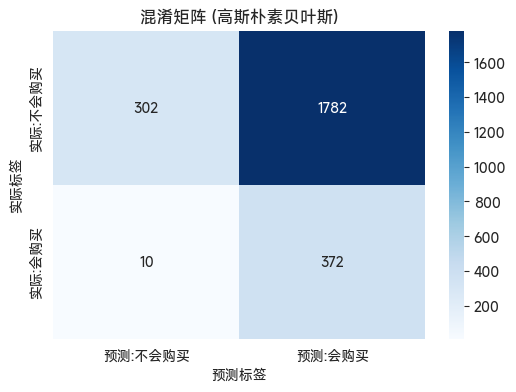

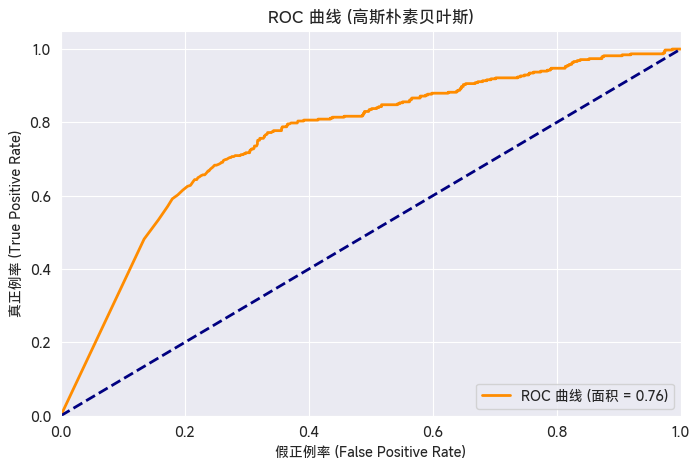

AUC值: 0.7597


In [6]:
# --- 从零实现高斯朴素贝叶斯 ---
class MyGaussianNaiveBayes:
    """
    自定义高斯朴素贝叶斯分类器。
    假设特征服从高斯分布。
    """

    def __init__(self, verbose=False):
        self.class_priors_ = None  # 各类别的先验概率 P(Y=c)
        self.class_means_ = None  # 各类别下各特征的均值 E[Xj | Y=c]
        self.class_vars_ = None  # 各类别下各特征的方差 Var(Xj | Y=c)
        self.classes_ = None  # 所有类别标签
        self.epsilon = 1e-9  # 防止除以零或log(0)的小常数
        self.verbose = verbose

    def fit(self, X, y):
        """
        训练高斯朴素贝叶斯模型。
        计算先验概率、各类别下特征的均值和方差。
        """
        if self.verbose: print("开始高斯朴素贝叶斯训练...")
        n_samples, n_features = X.shape
        self.classes_ = np.unique(y)  # 获取所有唯一类别
        n_classes = len(self.classes_)

        # 初始化存储参数的数组
        self.class_priors_ = np.zeros(n_classes)
        self.class_means_ = np.zeros((n_classes, n_features))
        self.class_vars_ = np.zeros((n_classes, n_features))

        for idx, c in enumerate(self.classes_):
            X_c = X[y == c]  # 取出类别c的所有样本
            self.class_priors_[idx] = X_c.shape[0] / n_samples  # P(Y=c) = Nc / N
            self.class_means_[idx, :] = X_c.mean(axis=0)  # E[Xj | Y=c]
            self.class_vars_[idx, :] = X_c.var(axis=0) + self.epsilon  # Var(Xj | Y=c)，加epsilon防方差为0

        if self.verbose: print("高斯朴素贝叶斯训练完成。")

    def _calculate_log_likelihood(self, class_idx, x_row):
        """计算给定样本x_row在类别class_idx下的对数似然 log(P(X=x_row | Y=c))。"""
        mean = self.class_means_[class_idx]
        var = self.class_vars_[class_idx]
        # 高斯分布的对数概率密度函数 log(P(xj | Y=c))
        # log(P) = -0.5 * log(2*pi*var) - 0.5 * ( (x - mean)^2 / var )
        # 对所有特征求和 (因为朴素贝叶斯假设特征条件独立)
        log_likelihood_terms = -0.5 * np.log(2 * np.pi * var) - 0.5 * ((x_row - mean) ** 2) / var
        return np.sum(log_likelihood_terms)

    def _calculate_log_posterior(self, x_row):
        """计算给定样本x_row属于每个类别的对数后验概率 log(P(Y=c | X=x_row))。"""
        log_posteriors = []
        for idx, c in enumerate(self.classes_):
            log_prior = np.log(self.class_priors_[idx] + self.epsilon)  # log(P(Y=c))
            log_likelihood = self._calculate_log_likelihood(idx, x_row)  # log(P(X=x_row | Y=c))
            log_posteriors.append(log_prior + log_likelihood)  # log(P(Y=c|X)) propto log(P(Y=c)) + log(P(X|Y=c))
        return np.array(log_posteriors)

    def predict_proba(self, X):
        """
        预测每个样本属于正类（类别1）的概率。
        使用log-sum-exp技巧进行归一化，避免数值下溢/上溢。
        """
        # 获取所有样本对于所有类别的对数后验概率（未归一化）
        log_posteriors_all = np.array([self._calculate_log_posterior(x_row) for x_row in X])

        # 使用log-sum-exp技巧进行归一化得到概率
        max_log = np.max(log_posteriors_all, axis=1, keepdims=True)  # 每行的最大值
        log_posteriors_shifted = log_posteriors_all - max_log  # 平移，使得最大值为0
        exp_log_posteriors_shifted = np.exp(log_posteriors_shifted)  # 计算指数
        sum_exp = np.sum(exp_log_posteriors_shifted, axis=1, keepdims=True)  # 每行求和
        probabilities = exp_log_posteriors_shifted / sum_exp  # 归一化得到概率

        # 假设是二分类，并且类别1是正类，通常在self.classes_的索引1处
        # 如果self.classes_是 [0, 1]，那么probabilities[:, 1] 是类别1的概率
        # 需要找到类别1在self.classes_中的索引
        idx_of_class_1 = np.where(self.classes_ == 1)[0]
        if len(idx_of_class_1) > 0:
            return probabilities[:, idx_of_class_1[0]]
        elif probabilities.shape[1] == 2:  # 如果只有两列且没找到1，默认第二列是正类
            return probabilities[:, 1]
        else:  # 多分类或单分类的特殊情况 (对于ROC通常只关心二分类的正类概率)
            print("警告: 无法明确识别正类(1)的概率，将返回所有类别的概率。ROC曲线可能不准确。")
            return probabilities  # 或者只返回第一列作为示例

    def predict(self, X):
        """根据最大的对数后验概率预测类别标签。"""
        predictions = []
        for x_row in X:
            log_posteriors = self._calculate_log_posterior(x_row)
            # 选择具有最大对数后验概率的类别
            predictions.append(self.classes_[np.argmax(log_posteriors)])
        return np.array(predictions)


# --- 训练自定义朴素贝叶斯模型 ---
print("\n--- 训练自定义高斯朴素贝叶斯模型 ---")
nb_model = MyGaussianNaiveBayes(verbose=True)
nb_model.fit(X_train, y_train)

y_pred_proba_nb = nb_model.predict_proba(X_test)  # 获取概率用于ROC曲线
y_pred_labels_nb = nb_model.predict(X_test)  # 获取类别标签

print("\n--- 高斯朴素贝叶斯模型评估 ---")
accuracy_nb = accuracy_score(y_test, y_pred_labels_nb)
print(f"准确率 (Accuracy): {accuracy_nb:.4f}")
print("\n分类报告:")
print(classification_report(y_test, y_pred_labels_nb, target_names=['不会购买 (0)', '会购买 (1)']))

print("\n混淆矩阵:")
cm_nb = confusion_matrix(y_test, y_pred_labels_nb)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', xticklabels=['预测:不会购买', '预测:会购买'],
            yticklabels=['实际:不会购买', '实际:会购买'])
plt.xlabel('预测标签')
plt.ylabel('实际标签')
plt.title('混淆矩阵 (高斯朴素贝叶斯)')
plt.show()

# ROC曲线和AUC
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_pred_proba_nb)  # 使用概率
roc_auc_nb = auc(fpr_nb, tpr_nb)
plt.figure(figsize=(8, 5))
plt.plot(fpr_nb, tpr_nb, color='darkorange', lw=2, label=f'ROC 曲线 (面积 = {roc_auc_nb:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('假正例率 (False Positive Rate)')
plt.ylabel('真正例率 (True Positive Rate)')
plt.title('ROC 曲线 (高斯朴素贝叶斯)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
print(f"AUC值: {roc_auc_nb:.4f}")


--- 训练自定义KNN模型 ---
KNN fit: 存储训练数据，k=15
KNN fit 完成。
KNN predict_proba: 开始预测概率...


KNN 预测概率中: 100%|██████████| 2466/2466 [01:04<00:00, 37.96it/s]


KNN predict_proba 完成。
KNN predict: 开始预测...


KNN 预测中: 100%|██████████| 2466/2466 [01:05<00:00, 37.38it/s]


KNN predict 完成。

--- KNN模型评估 ---
准确率 (Accuracy): 0.8755

分类报告:
              precision    recall  f1-score   support

    不会购买 (0)       0.89      0.97      0.93      2084
     会购买 (1)       0.70      0.34      0.46       382

    accuracy                           0.88      2466
   macro avg       0.80      0.66      0.69      2466
weighted avg       0.86      0.88      0.86      2466


混淆矩阵:


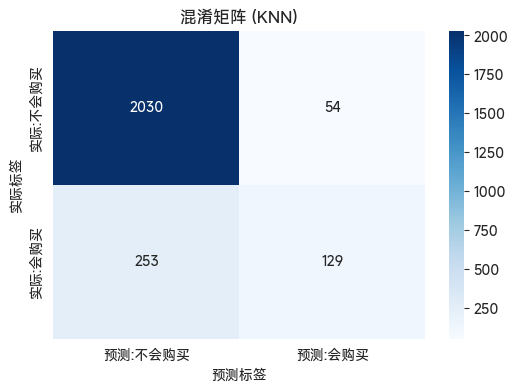

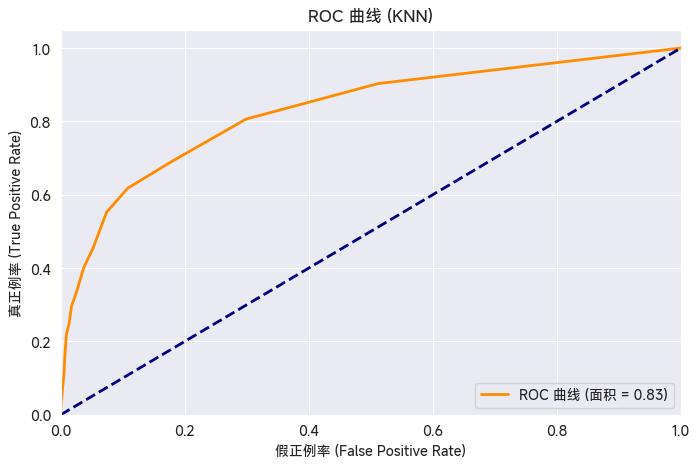

AUC值: 0.8300


In [7]:
# --- 从零实现K-Nearest Neighbors ---
class MyKNearestNeighbors:
    """
    自定义K近邻分类器。
    """

    def __init__(self, k=3, verbose=False):
        """
        初始化函数。
        参数:
            k (int): 邻居的数量。
            verbose (bool): 是否在预测时显示进度条。
        """
        self.k = k
        self.X_train = None  # 训练数据特征
        self.y_train = None  # 训练数据标签
        self.verbose = verbose

    def fit(self, X_train, y_train):
        """存储训练数据。KNN是懒惰学习算法，fit阶段只存储数据。"""
        if self.verbose: print(f"KNN fit: 存储训练数据，k={self.k}")
        self.X_train = X_train
        self.y_train = y_train
        if self.verbose: print("KNN fit 完成。")

    def _euclidean_distance(self, x1, x2):
        """计算两个样本点之间的欧氏距离。"""
        return np.sqrt(np.sum((x1 - x2) ** 2))

    def _get_k_neighbors_labels(self, x_test_sample):
        """获取单个测试样本的k个最近邻的标签。"""
        # 计算测试样本与所有训练样本的距离
        distances = [self._euclidean_distance(x_test_sample, x_train_sample) for x_train_sample in self.X_train]
        # 获取距离最近的k个训练样本的索引
        k_indices = np.argsort(distances)[:self.k]
        # 获取这些最近邻的标签
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        return k_nearest_labels

    def _predict_single(self, x_test_sample):
        """预测单个测试样本的类别（通过多数投票）。"""
        k_nearest_labels = self._get_k_neighbors_labels(x_test_sample)
        # 多数投票决定类别
        most_common = Counter(k_nearest_labels).most_common(1)
        return most_common[0][0]

    def _predict_proba_single(self, x_test_sample):
        """预测单个测试样本属于正类（类别1）的概率。"""
        k_nearest_labels = self._get_k_neighbors_labels(x_test_sample)
        # 计算k个近邻中类别1的比例作为概率
        prob_positive = sum(1 for label in k_nearest_labels if label == 1) / self.k
        return prob_positive

    def predict(self, X_test):
        """预测测试数据集的类别标签。"""
        if self.verbose:
            print("KNN predict: 开始预测...")
            predictions = [self._predict_single(x_test_sample) for x_test_sample in tqdm(X_test, desc="KNN 预测中")]
        else:
            predictions = [self._predict_single(x_test_sample) for x_test_sample in X_test]
        if self.verbose: print("KNN predict 完成。")
        return np.array(predictions)

    def predict_proba(self, X_test):
        """预测测试数据集每个样本属于正类（类别1）的概率。"""
        if self.verbose:
            print("KNN predict_proba: 开始预测概率...")
            probabilities = [self._predict_proba_single(x_test_sample) for x_test_sample in
                             tqdm(X_test, desc="KNN 预测概率中")]
        else:
            probabilities = [self._predict_proba_single(x_test_sample) for x_test_sample in X_test]
        if self.verbose: print("KNN predict_proba 完成。")
        return np.array(probabilities)


# --- 训练自定义KNN模型 ---
print("\n--- 训练自定义KNN模型 ---")
knn_model = MyKNearestNeighbors(k=15, verbose=True)  # k值可以调整，增加verbose
knn_model.fit(X_train, y_train)

y_pred_proba_knn = knn_model.predict_proba(X_test)  # 获取概率用于ROC曲线
y_pred_labels_knn = knn_model.predict(X_test)  # 获取类别标签

print("\n--- KNN模型评估 ---")
accuracy_knn = accuracy_score(y_test, y_pred_labels_knn)
print(f"准确率 (Accuracy): {accuracy_knn:.4f}")
print("\n分类报告:")
print(classification_report(y_test, y_pred_labels_knn, target_names=['不会购买 (0)', '会购买 (1)']))

print("\n混淆矩阵:")
cm_knn = confusion_matrix(y_test, y_pred_labels_knn)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', xticklabels=['预测:不会购买', '预测:会购买'],
            yticklabels=['实际:不会购买', '实际:会购买'])
plt.xlabel('预测标签')
plt.ylabel('实际标签')
plt.title('混淆矩阵 (KNN)')
plt.show()

# ROC曲线和AUC
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_pred_proba_knn)  # 使用概率
roc_auc_knn = auc(fpr_knn, tpr_knn)
plt.figure(figsize=(8, 5))
plt.plot(fpr_knn, tpr_knn, color='darkorange', lw=2, label=f'ROC 曲线 (面积 = {roc_auc_knn:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('假正例率 (False Positive Rate)')
plt.ylabel('真正例率 (True Positive Rate)')
plt.title('ROC 曲线 (KNN)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
print(f"AUC值: {roc_auc_knn:.4f}")


实验 1: Online Shoppers Intention 数据集上的模型比较

重新评估决策树 (基准模型) 在 Online Shoppers 数据集上的表现...

--- 决策树 (基准) 模型评估 (Online Shoppers) ---
准确率 (Accuracy): 0.8954

分类报告:
              precision    recall  f1-score   support

        类别 0       0.92      0.96      0.94      2084
        类别 1       0.70      0.57      0.63       382

    accuracy                           0.90      2466
   macro avg       0.81      0.76      0.78      2466
weighted avg       0.89      0.90      0.89      2466


混淆矩阵:


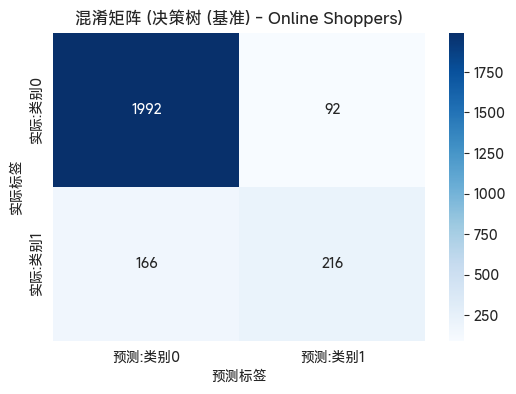

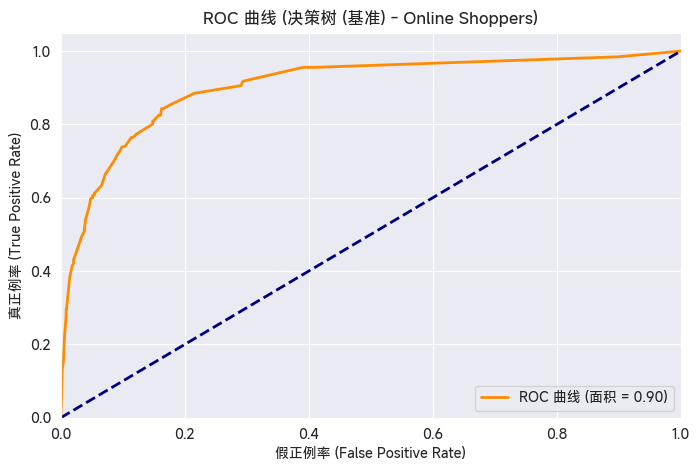

AUC值: 0.9028

训练并评估随机森林 (改进模型) 在 Online Shoppers 数据集上的表现...
开始随机森林训练，树的数量=50, 每棵树最大特征数=8 (基于 'sqrt')


随机森林训练中: 100%|██████████| 50/50 [00:12<00:00,  3.91it/s]


随机森林训练完成。

--- 随机森林 (改进) 模型评估 (Online Shoppers) ---
准确率 (Accuracy): 0.8938

分类报告:
              precision    recall  f1-score   support

        类别 0       0.90      0.98      0.94      2084
        类别 1       0.80      0.42      0.55       382

    accuracy                           0.89      2466
   macro avg       0.85      0.70      0.74      2466
weighted avg       0.89      0.89      0.88      2466


混淆矩阵:


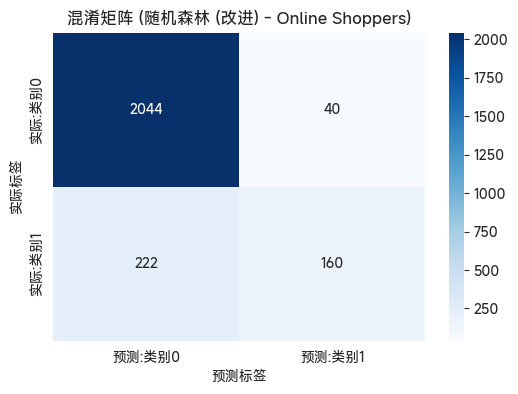

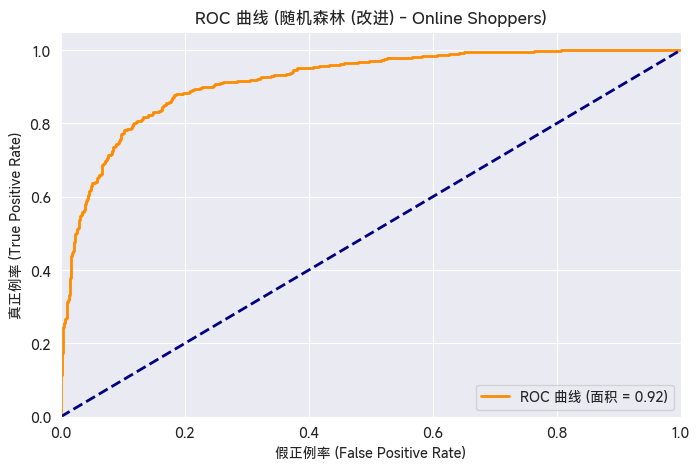

AUC值: 0.9167

--- 随机森林特征重要性 ---


/home/grtsinry43/.conda/envs/ml/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


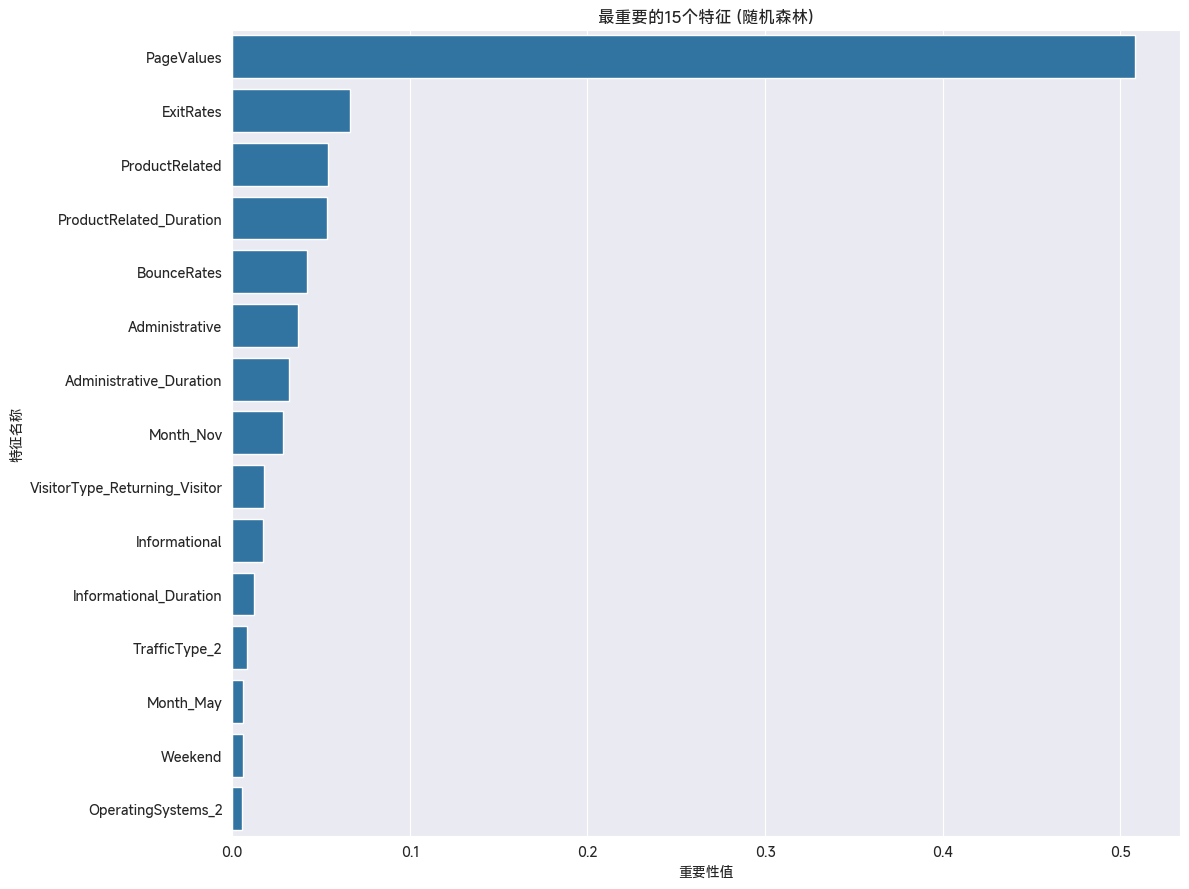


实验 2: 乳腺癌数据集上的模型比较
乳腺癌数据集特征 (前5行):
   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   mean fractal dimension  ...  worst radius  worst text

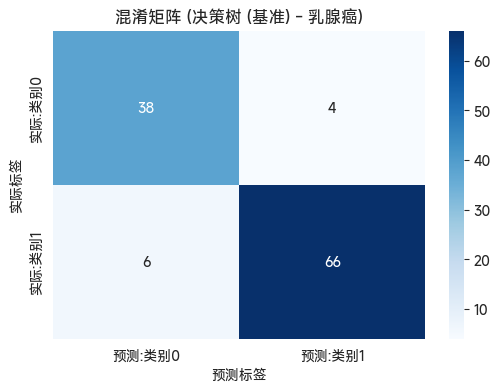

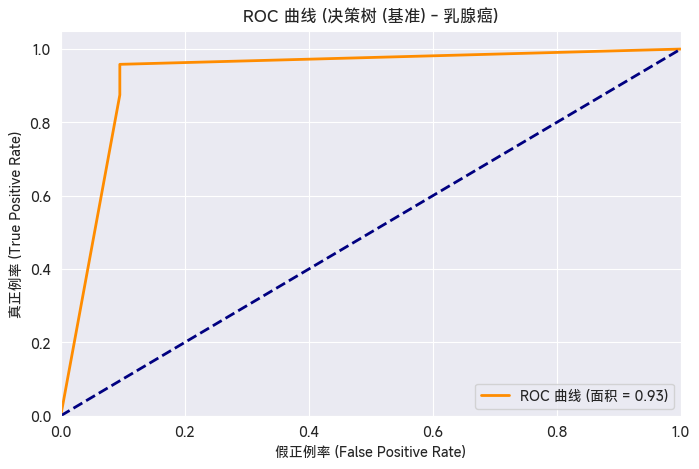

AUC值: 0.9276

训练并评估随机森林 (改进模型) 在乳腺癌数据集上的表现...
开始随机森林训练，树的数量=50, 每棵树最大特征数=5 (基于 'sqrt')


随机森林训练中: 100%|██████████| 50/50 [00:00<00:00, 52.47it/s]


随机森林训练完成。

--- 随机森林 (改进) 模型评估 (乳腺癌) ---
准确率 (Accuracy): 0.9561

分类报告:
              precision    recall  f1-score   support

        类别 0       0.93      0.95      0.94        42
        类别 1       0.97      0.96      0.97        72

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114


混淆矩阵:


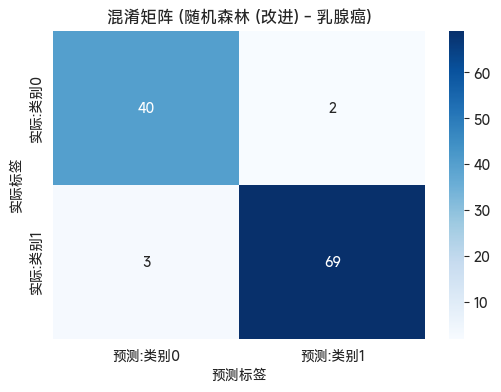

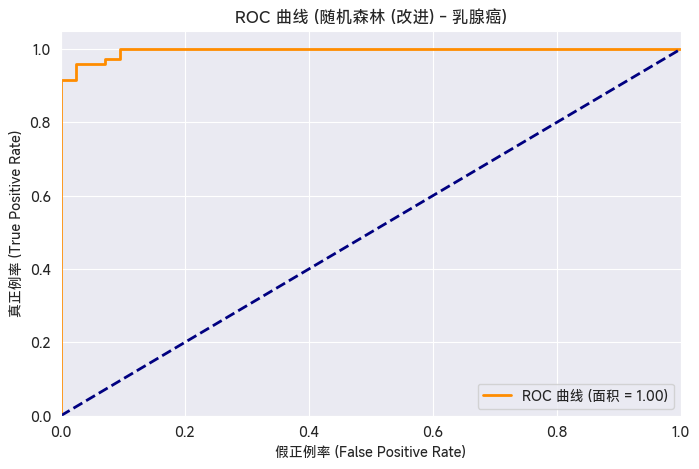

AUC值: 0.9954

--- 随机森林特征重要性 (乳腺癌) ---


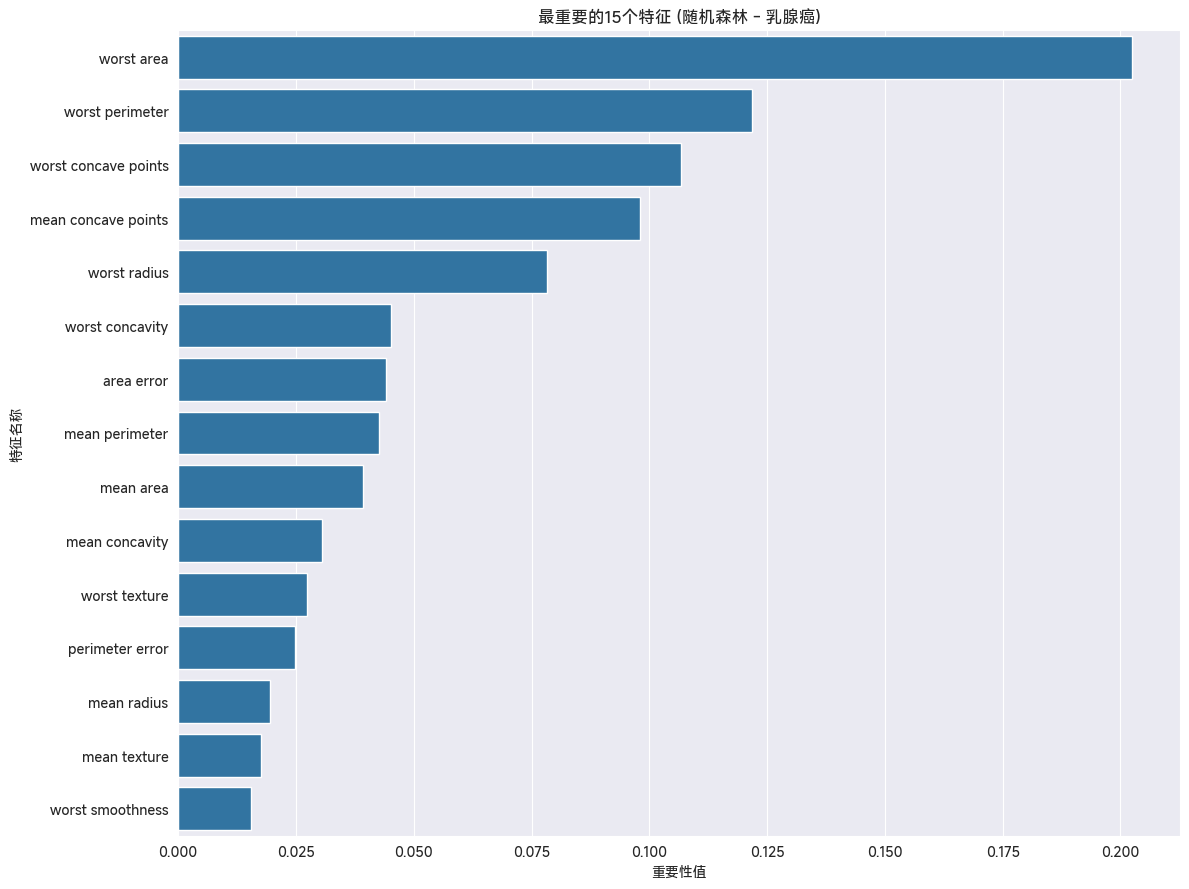

In [8]:
# --- Part 2: 实现改进算法 (随机森林 MyRandomForestClassifier) ---
# 随机森林是决策树的一种集成学习改进方法。
# 它依赖于我们之前实现的 MyDecisionTreeClassifier，并确保其支持特征子抽样 (`max_features`)。

class MyRandomForestClassifier:
    """
    自定义随机森林分类器。
    """

    def __init__(self, n_estimators=100, max_depth=None, min_samples_split=2,
                 criterion='gini', max_features='sqrt', random_state=None, verbose=False):
        """
        初始化函数。
        参数:
            n_estimators (int): 森林中树的数量。
            max_depth (int, optional): 每棵树的最大深度。
            min_samples_split (int): 每棵树节点分裂所需的最小样本数。
            criterion (str): 每棵树的不纯度度量标准。
            max_features (str, int, float): 每棵树寻找最佳分裂时考虑的特征数量。
                                           'sqrt': sqrt(n_features)
                                           'log2': log2(n_features)
                                           int: 具体数量
                                           float: n_features * float (比例)
            random_state (int, optional): 随机种子，用于结果可复现。
            verbose (bool): 是否打印训练过程信息。
        """
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.criterion = criterion
        self.max_features_mode = max_features  # 保存原始的max_features设置
        self.random_state = random_state
        self.trees = []  # 存储森林中的所有决策树
        self.feature_importances_ = None  # 特征重要性
        self.verbose = verbose
        self.actual_max_features_val = None  # 实际计算出的 max_features 整数值

    def _get_actual_max_features(self, n_total_features):
        """根据输入模式计算实际使用的特征数量。"""
        if self.max_features_mode is None:
            return n_total_features
        if isinstance(self.max_features_mode, str):
            if self.max_features_mode == 'sqrt':
                val = int(np.sqrt(n_total_features))
            elif self.max_features_mode == 'log2':
                val = int(np.log2(n_total_features)) if np.log2(n_total_features) >= 1 else 1
            else:  # 未识别的字符串，使用所有特征
                print(f"警告: 未识别的 max_features 字符串 '{self.max_features_mode}', 将使用所有特征。")
                val = n_total_features
        elif isinstance(self.max_features_mode, float) and 0 < self.max_features_mode <= 1.0:  # 比例
            val = int(self.max_features_mode * n_total_features)
        elif isinstance(self.max_features_mode, int):  # 具体数量
            val = self.max_features_mode
        else:  # 其他无效输入，使用所有特征
            print(f"警告: 无效的 max_features 输入 '{self.max_features_mode}', 将使用所有特征。")
            val = n_total_features

        return max(1, min(val, n_total_features))  # 确保在 [1, n_total_features] 范围内

    def fit(self, X, y):
        """训练随机森林模型。"""
        self.trees = []
        n_samples, n_features = X.shape

        if self.random_state is not None:
            np.random.seed(self.random_state)  # 设置随机种子

        # 计算实际的 max_features 值 (整数)
        self.actual_max_features_val = self._get_actual_max_features(n_features)
        if self.verbose:
            print(
                f"开始随机森林训练，树的数量={self.n_estimators}, 每棵树最大特征数={self.actual_max_features_val} (基于 '{self.max_features_mode}')")

        self.feature_importances_ = np.zeros(n_features)  # 初始化特征重要性

        desc = "随机森林训练中" if self.verbose else None
        for i in tqdm(range(self.n_estimators), desc=desc, disable=not self.verbose):
            # 1. Bootstrap自助采样 (有放回抽样)
            #    为每棵树生成一个与原始训练集大小相同的自助样本集
            indices = np.random.choice(n_samples, n_samples, replace=True)
            X_sample, y_sample = X[indices], y[indices]

            # 2. 为每棵树训练一个决策树模型
            tree = MyDecisionTreeClassifier(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                criterion=self.criterion,
                max_features=self.actual_max_features_val  # 传递计算好的特征数量
            )
            # tree.verbose = False # 单个树的训练过程通常不打印
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

            # 3. 累积特征重要性 (简化版：基于基尼增益或信息增益)
            #    更复杂的方法会考虑分裂带来的不纯度减少量，并进行归一化
            self._accumulate_feature_importances(tree.tree, n_features, X_sample.shape[0])

        # 归一化特征重要性
        if np.sum(self.feature_importances_) > 0:
            self.feature_importances_ /= np.sum(self.feature_importances_)

        if self.verbose: print("随机森林训练完成。")

    def _accumulate_feature_importances(self, node, n_total_features, n_tree_root_samples):
        """递归累积单个树的特征重要性。"""
        if node['is_leaf']:  # 如果是叶节点，则终止
            return

        # 重要性计算方式: (该分裂带来的不纯度减少 * 该节点样本数) / 树的根节点样本数
        # node['info_gain'] 是 (父节点不纯度 - 子节点加权不纯度)
        # node['samples'] 是该节点的样本数
        # 这里的 'info_gain' 实际上是 impurity_decrease
        if 'info_gain' in node and node['info_gain'] > 0 and 'feature_index' in node:
            # 在这里，我们使用 (info_gain * node_samples) 作为未标准化的重要性贡献
            # 最后会在所有树累积完后，除以所有贡献的总和来归一化
            # 或者，更标准的做法是除以当前树的根节点样本数，然后再在所有树之间平均
            # 这里我们用一个简化版本：直接累加 (info_gain * node_samples / n_tree_root_samples)
            # 保证 feature_index 在范围内
            if 0 <= node['feature_index'] < len(self.feature_importances_):
                self.feature_importances_[node['feature_index']] += (node['info_gain'] * node[
                    'samples']) / n_tree_root_samples
            else:
                print(f"警告: 特征索引 {node['feature_index']} 超出范围 [0, {len(self.feature_importances_) - 1}]。")

        # 递归到子节点
        if 'left' in node and isinstance(node['left'], dict):
            self._accumulate_feature_importances(node['left'], n_total_features, n_tree_root_samples)
        if 'right' in node and isinstance(node['right'], dict):
            self._accumulate_feature_importances(node['right'], n_total_features, n_tree_root_samples)

    def predict_proba(self, X):
        """
        预测每个样本属于正类（类别1）的概率。
        通过平均森林中所有树的概率预测得到。
        """
        # 收集所有树对每个样本的概率预测 (每棵树预测的是类别1的概率)
        # tree_probas 的形状将是 (n_estimators, n_samples)
        tree_probas = np.array([tree.predict_proba(X) for tree in self.trees])
        # 对所有树的概率进行平均，得到最终概率
        # axis=0 表示沿着树的维度（第一个维度）进行平均
        return np.mean(tree_probas, axis=0)  # 返回形状为 (n_samples,) 的数组

    def predict(self, X):
        """
        预测类别标签。
        通过森林中所有树的多数投票得到。
        """
        # 收集所有树对每个样本的类别预测
        # tree_preds 的形状将是 (n_estimators, n_samples)
        tree_preds = np.array([tree.predict(X) for tree in self.trees])

        # 进行多数投票
        # 将 tree_preds 转置为 (n_samples, n_estimators)，方便对每个样本进行投票
        predictions = []
        for sample_preds_from_all_trees in tree_preds.T:
            # Counter统计每个类别出现的次数，most_common(1)返回出现次数最多的类别及其计数
            most_common_class = Counter(sample_preds_from_all_trees).most_common(1)[0][0]
            predictions.append(most_common_class)
        return np.array(predictions)


# --- 辅助评估函数 ---
def evaluate_model(model, X_test_data, y_test_data, model_name_cn, dataset_name_cn):
    """
    评估已训练模型的性能。
    参数:
        model: 已训练的模型对象。
        X_test_data (numpy.ndarray): 测试集特征。
        y_test_data (numpy.ndarray): 测试集标签。
        model_name_cn (str): 模型名称 (中文)。
        dataset_name_cn (str): 数据集名称 (中文)。
    返回:
        tuple: (accuracy, roc_auc)
    """
    print(f"\n--- {model_name_cn} 模型评估 ({dataset_name_cn}) ---")

    # 获取概率预测 (用于ROC曲线)
    if hasattr(model, 'predict_proba'):
        y_pred_proba_model = model.predict_proba(X_test_data)
    else:  # 备用方案：如果模型没有predict_proba方法 (理论上我们都实现了)
        print(f"警告: 模型 {model_name_cn} 没有 predict_proba 方法，ROC曲线可能不准确。")
        y_pred_proba_model = model.predict(X_test_data)  # 这会导致阶梯状ROC

    # 获取类别标签预测
    y_pred_labels_model = model.predict(X_test_data)

    accuracy_model = accuracy_score(y_test_data, y_pred_labels_model)
    print(f"准确率 (Accuracy): {accuracy_model:.4f}")
    print("\n分类报告:")
    # 使用 '类别 0' 和 '类别 1' 作为通用名称
    print(classification_report(y_test_data, y_pred_labels_model, target_names=['类别 0', '类别 1'], zero_division=0))

    print("\n混淆矩阵:")
    cm_model = confusion_matrix(y_test_data, y_pred_labels_model)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_model, annot=True, fmt='d', cmap='Blues', xticklabels=['预测:类别0', '预测:类别1'],
                yticklabels=['实际:类别0', '实际:类别1'])
    plt.xlabel('预测标签')
    plt.ylabel('实际标签')
    plt.title(f'混淆矩阵 ({model_name_cn} - {dataset_name_cn})')
    plt.show()

    # ROC曲线和AUC
    fpr_model, tpr_model, _ = roc_curve(y_test_data, y_pred_proba_model)
    roc_auc_model = auc(fpr_model, tpr_model)
    plt.figure(figsize=(8, 5))
    plt.plot(fpr_model, tpr_model, color='darkorange', lw=2, label=f'ROC 曲线 (面积 = {roc_auc_model:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('假正例率 (False Positive Rate)')
    plt.ylabel('真正例率 (True Positive Rate)')
    plt.title(f'ROC 曲线 ({model_name_cn} - {dataset_name_cn})')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
    print(f"AUC值: {roc_auc_model:.4f}")
    return accuracy_model, roc_auc_model


# --- 实验 1: Online Shoppers Intention 数据集 ---
print("\n" + "=" * 60)
print("实验 1: Online Shoppers Intention 数据集上的模型比较")
print("=" * 60)

# X_train, X_test, y_train, y_test 已经为这个数据集定义和处理好了

print("\n重新评估决策树 (基准模型) 在 Online Shoppers 数据集上的表现...")
# 使用之前训练好的 tree_model
evaluate_model(tree_model, X_test, y_test, "决策树 (基准)", "Online Shoppers")

print("\n训练并评估随机森林 (改进模型) 在 Online Shoppers 数据集上的表现...")
rf_model_shoppers = MyRandomForestClassifier(
    n_estimators=50,  # 为加速示例，实际应用中100-200更常见
    max_depth=10,  # 随机森林中的树可以更深一些
    min_samples_split=5,
    max_features='sqrt',  # 常用默认值: sqrt(总特征数)
    random_state=42,  # 保证结果可复现
    verbose=True  # 开启详细输出
)
rf_model_shoppers.fit(X_train, y_train)
evaluate_model(rf_model_shoppers, X_test, y_test, "随机森林 (改进)", "Online Shoppers")

# 显示随机森林的特征重要性
if hasattr(rf_model_shoppers, 'feature_importances_') and rf_model_shoppers.feature_importances_ is not None:
    print("\n--- 随机森林特征重要性 ---")
    try:
        # 尝试获取预处理后的特征名称 (这部分比较复杂)
        # 数值特征名称
        num_feat_names = list(preprocessor.transformers_[0][2])  # numerical_features
        # 类别特征名称 (来自OneHotEncoder)
        cat_transformer = preprocessor.named_transformers_['cat']
        if hasattr(cat_transformer, 'get_feature_names_out'):
            cat_feat_names = list(cat_transformer.get_feature_names_out(all_categorical_features))
        else:  # 兼容旧版sklearn或不同配置的OneHotEncoder
            # 这是一个简化的回退逻辑，实际名称可能更复杂，特别是当 drop='first' 时
            cat_feat_names = []
            for i, col_name in enumerate(all_categorical_features):
                unique_vals = sorted(df[col_name].astype(str).unique())  # 确保是字符串并排序
                # 如果 drop='first'，第一个类别会被丢弃
                start_idx = 1 if cat_transformer.drop == 'first' and len(unique_vals) > 1 else 0
                for val_idx in range(start_idx, len(unique_vals)):
                    cat_feat_names.append(f"{col_name}_{unique_vals[val_idx]}")

        # 'remainder' 中保留的特征名称 (例如 'Weekend')
        remainder_cols = []
        if preprocessor.remainder == 'passthrough' and len(preprocessor.transformers_) > 1 and len(
                preprocessor.transformers_[-1][2]) > 0:
            # preprocessor.transformers_[-1] 应该是 ('remainder', 'passthrough', [col_indices])
            # X.columns[i] for i in preprocessor.transformers_[-1][2]
            # 这里需要原始X的列名
            original_X_cols = X.columns
            remainder_indices = preprocessor.transformers_[-1][2]
            remainder_cols = [original_X_cols[i] for i in remainder_indices]

        all_feature_names_processed = num_feat_names + cat_feat_names + remainder_cols

        if len(all_feature_names_processed) == X_train.shape[1]:
            importances = pd.Series(rf_model_shoppers.feature_importances_, index=all_feature_names_processed)
            top_importances = importances.sort_values(ascending=False).head(15)  # 取最重要的15个

            plt.figure(figsize=(12, 9))  # 增大图像尺寸以便容纳更多特征名
            sns.barplot(x=top_importances.values, y=top_importances.index)
            plt.title('最重要的15个特征 (随机森林)')
            plt.xlabel('重要性值')
            plt.ylabel('特征名称')
            plt.tight_layout()  # 自动调整布局
            plt.show()
        else:
            print(
                f"警告: 无法准确匹配所有特征名称 (预期 {X_train.shape[1]} 个, 得到 {len(all_feature_names_processed)} 个)。")
            print(f"  数值特征数: {len(num_feat_names)}")
            print(f"  OneHot编码后类别特征数: {len(cat_feat_names)}")
            print(f"  保留特征数: {len(remainder_cols)}")
            print("  将不绘制特征重要性图。请检查 OneHotEncoder 的 get_feature_names_out 行为。")

    except Exception as e:
        print(f"绘制特征重要性图时发生错误: {e}")
        print("特征重要性图已跳过。")

# --- 实验 2: 乳腺癌数据集 (来自 sklearn.datasets) ---
print("\n" + "=" * 60)
print("实验 2: 乳腺癌数据集上的模型比较")
print("=" * 60)

# 加载数据
cancer = load_breast_cancer()
X_cancer_raw = pd.DataFrame(cancer.data, columns=cancer.feature_names)
y_cancer = pd.Series(cancer.target)  # 0: malignant (恶性), 1: benign (良性)

print("乳腺癌数据集特征 (前5行):")
print(X_cancer_raw.head())
print("\n乳腺癌数据集目标变量分布:")
print(y_cancer.value_counts(normalize=True))  # 0 和 1 的比例

# 数据预处理: 此数据集特征均为数值型，只需进行标准化
scaler_cancer = StandardScaler()
X_cancer_scaled = scaler_cancer.fit_transform(X_cancer_raw)

# 划分训练集和测试集
X_train_bc, X_test_bc, y_train_bc, y_test_bc = train_test_split(
    X_cancer_scaled, y_cancer.values, test_size=0.2, random_state=42, stratify=y_cancer
)

print(f"\n训练集大小 (乳腺癌): X_train: {X_train_bc.shape}, y_train: {y_train_bc.shape}")
print(f"测试集大小 (乳腺癌): X_test: {X_test_bc.shape}, y_test: {y_test_bc.shape}")

# 训练并评估决策树 (基准模型)
print("\n训练并评估决策树 (基准模型) 在乳腺癌数据集上的表现...")
tree_model_bc = MyDecisionTreeClassifier(max_depth=5, min_samples_split=5, criterion='gini')
tree_model_bc.verbose = True  # 可以设为 False 以减少输出
tree_model_bc.fit(X_train_bc, y_train_bc)
evaluate_model(tree_model_bc, X_test_bc, y_test_bc, "决策树 (基准)", "乳腺癌")

# 训练并评估随机森林 (改进模型)
print("\n训练并评估随机森林 (改进模型) 在乳腺癌数据集上的表现...")
rf_model_bc = MyRandomForestClassifier(
    n_estimators=50,  # 为加速示例
    max_depth=7,
    min_samples_split=5,
    max_features='sqrt',
    random_state=42,
    verbose=True
)
rf_model_bc.fit(X_train_bc, y_train_bc)
evaluate_model(rf_model_bc, X_test_bc, y_test_bc, "随机森林 (改进)", "乳腺癌")

# 显示随机森林的特征重要性 (乳腺癌数据集)
if hasattr(rf_model_bc, 'feature_importances_') and rf_model_bc.feature_importances_ is not None:
    print("\n--- 随机森林特征重要性 (乳腺癌) ---")
    importances_bc = pd.Series(rf_model_bc.feature_importances_, index=cancer.feature_names)
    top_importances_bc = importances_bc.sort_values(ascending=False).head(15)

    plt.figure(figsize=(12, 9))
    sns.barplot(x=top_importances_bc.values, y=top_importances_bc.index)
    plt.title('最重要的15个特征 (随机森林 - 乳腺癌)')
    plt.xlabel('重要性值')
    plt.ylabel('特征名称')
    plt.tight_layout()
    plt.show()